In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
from torch.utils.data import Subset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import numpy as np
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" usando dispositivo:", device)


 Usando dispositivo: cpu


In [3]:


class CheXNet(nn.Module):
    def __init__(self, num_classes=14):
        super(CheXNet, self).__init__()
        weights = DenseNet121_Weights.DEFAULT
        densenet = densenet121(weights=weights)
        num_features = densenet.classifier.in_features
        densenet.classifier = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()
        )
        self.model = densenet

    def forward(self, x):
        return self.model(x)


In [4]:
class ChestXRayDataset(Dataset):
    def __init__(self, parquet_file, image_dir, transform=None):
        self.data = pd.read_parquet(parquet_file)
        self.image_dir = image_dir
        self.transform = transform

        self.labels = self.data['patologia'].str.split('|')
        self.labels = self.labels.apply(lambda lbls: [l for l in lbls if l != "No Finding"])

        self.mlb = MultiLabelBinarizer()
        self.targets = self.mlb.fit_transform(self.labels)
        self.label_classes = self.mlb.classes_

        print(f" {len(self.label_classes)} classes: {self.label_classes.tolist()}")
        np.save('../classes.npy', self.label_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data.iloc[idx]['index_da_imagem'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.FloatTensor(self.targets[idx])
        return image, label


In [10]:



parquet_path = "/datalake/gold/paciente_gold.parquet"
image_dir = "/data/chest_x-ray/images"
batch_size = 32
epochs = 5


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


dataset = ChestXRayDataset(parquet_path, image_dir, transform=transform)


subset_indices = np.random.choice(len(dataset), 20000, replace=False)
subset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)


🔍 14 classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [11]:
model = CheXNet(num_classes=len(dataset.label_classes)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 0:
            print(f" epoch {epoch+1} | batch {i}/{len(dataloader)} | loss: {loss.item():.4f}")

    print(f" [epoca {epoch+1}] loss medio: {running_loss / len(dataloader):.4f}")


 Iniciando treinamento...
 Epoch 1 | Batch 0/157 | Loss: 0.6342
 Epoch 1 | Batch 50/157 | Loss: 0.1725
 Epoch 1 | Batch 100/157 | Loss: 0.1688
 Epoch 1 | Batch 150/157 | Loss: 0.1942
✅ [Época 1] Loss médio: 0.2345
 Epoch 2 | Batch 0/157 | Loss: 0.1651
 Epoch 2 | Batch 50/157 | Loss: 0.1505
 Epoch 2 | Batch 100/157 | Loss: 0.1642
 Epoch 2 | Batch 150/157 | Loss: 0.1192
✅ [Época 2] Loss médio: 0.1551
 Epoch 3 | Batch 0/157 | Loss: 0.1439
 Epoch 3 | Batch 50/157 | Loss: 0.1434
 Epoch 3 | Batch 100/157 | Loss: 0.1547
 Epoch 3 | Batch 150/157 | Loss: 0.1372
✅ [Época 3] Loss médio: 0.1329
 Epoch 4 | Batch 0/157 | Loss: 0.0859
 Epoch 4 | Batch 50/157 | Loss: 0.0860
 Epoch 4 | Batch 100/157 | Loss: 0.0805
 Epoch 4 | Batch 150/157 | Loss: 0.1669
✅ [Época 4] Loss médio: 0.1045
 Epoch 5 | Batch 0/157 | Loss: 0.1271
 Epoch 5 | Batch 50/157 | Loss: 0.0723
 Epoch 5 | Batch 100/157 | Loss: 0.0946
 Epoch 5 | Batch 150/157 | Loss: 0.0989
✅ [Época 5] Loss médio: 0.0754


In [2]:



all_y_true = []
all_y_scores = []

model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        all_y_true.append(labels.cpu().numpy())
        all_y_scores.append(outputs.cpu().numpy())


y_true = np.vstack(all_y_true)
y_scores = np.vstack(all_y_scores)


y_pred = (y_scores > 0.5).astype(int)


label_classes = dataset.label_classes


print(classification_report(y_true, y_pred, target_names=label_classes))


NameError: name 'model' is not defined

In [12]:



def show_image(img_tensor, true_labels=None, pred_labels=None, label_classes=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    title = ""

    if true_labels is not None and label_classes is not None:
        true_str = ", ".join([label_classes[i] for i in range(len(true_labels)) if true_labels[i] == 1])
        title += f" GT: {true_str}"

    if pred_labels is not None and label_classes is not None:
        pred_str = ", ".join([label_classes[i] for i in range(len(pred_labels)) if pred_labels[i] == 1])
        title += f"\n Pred: {pred_str}"

    plt.title(title, fontsize=10)
    plt.axis("off")
    plt.show()

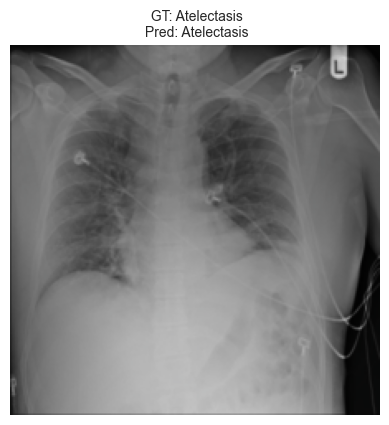

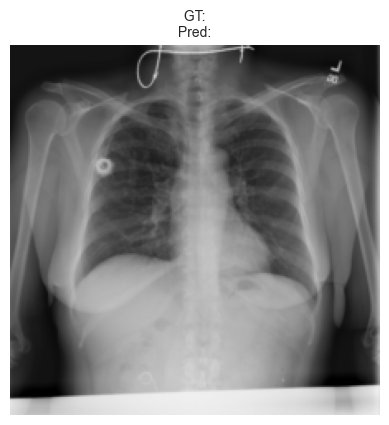

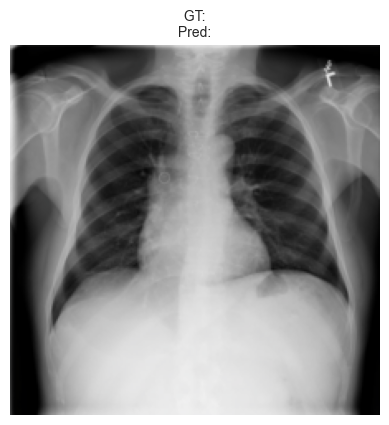

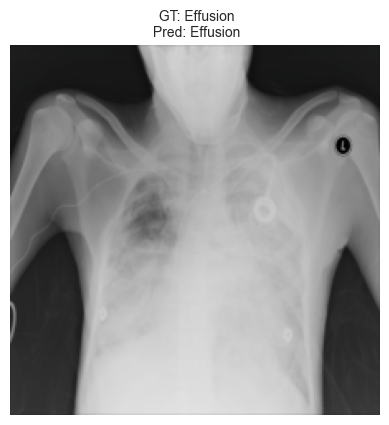

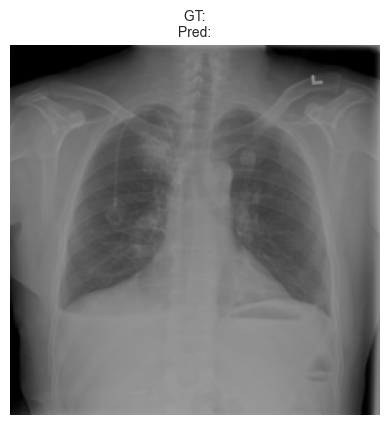

In [19]:

sample_batch = next(iter(dataloader))
images, labels = sample_batch
images = images.to(device)


model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).int().cpu()


label_classes = np.load("../classes.npy", allow_pickle=True)


for i in range(5):
    show_image(images[i].cpu(), true_labels=labels[i].int().numpy(),
               pred_labels=preds[i].numpy(), label_classes=label_classes)


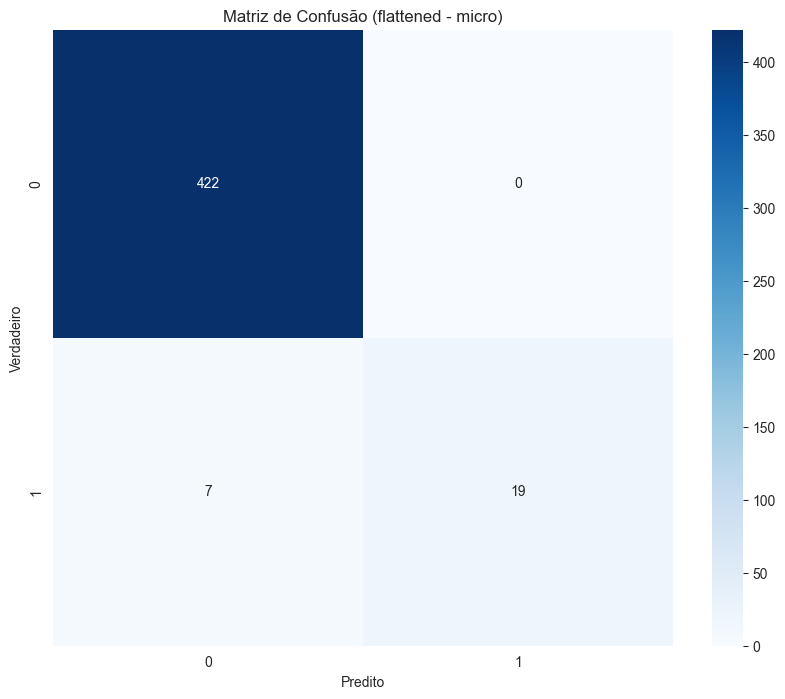

In [22]:

y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()
class_names = label_classes.tolist()


fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_true.ravel(), y_pred.ravel())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title("Matriz de Confusão (flattened - micro)")
ax.set_xlabel("Predito")
ax.set_ylabel("Verdadeiro")
plt.show()

In [1]:


y_true = labels.cpu().numpy()
y_scores = torch.sigmoid(outputs).detach().cpu().numpy()


plt.figure(figsize=(12, 10))

for i in range(len(label_classes)):
    if np.sum(y_true[:, i]) == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por Classe (AUC)')
plt.legend(loc='lower right', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'labels' is not defined

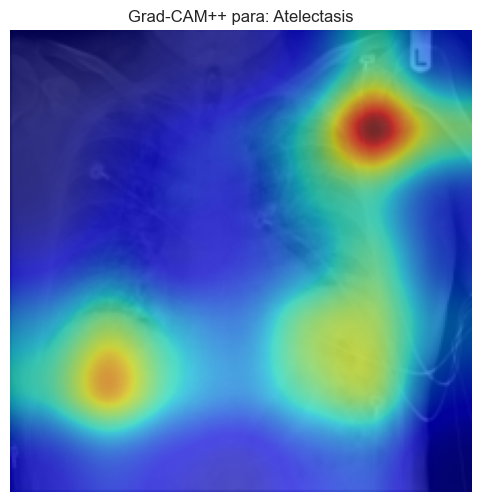

In [31]:


# Define a camada alvo: última convolução antes do avgpool
target_layer = model.model.features[-1]  # ou model.model.features.denseblock4

# Inicializa o interpretador Grad-CAM++
cam_extractor = SmoothGradCAMpp(model=model.model, target_layer=target_layer)

# Seleciona uma imagem do batch e garante que exige gradiente
img_tensor = images[0].unsqueeze(0).to(device)
img_tensor = img_tensor.clone().detach().requires_grad_(True)

# Forward pass SEM torch.no_grad()
model.eval()
output = model(img_tensor)

# Escolher a classe com maior score para visualização
target_class = torch.argmax(output[0]).item()

# Gera o mapa de ativação (Grad-CAM++)
activation_map = cam_extractor(class_idx=target_class, scores=output)[0]

# Reconstrói a imagem original (unnormalize)
img = img_tensor.squeeze().cpu()
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img = img.clamp(0, 1)

# Combina imagem e mapa com overlay
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.4)

# Exibe o resultado
plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.title(f"Grad-CAM++ para: {label_classes[target_class]}")
plt.axis('off')
plt.show()


In [17]:
torch.save(model.state_dict(), "/scripts/models/chexnet_model.pth")
print(" Modelo salvo como chexnet_model.pth")


 Modelo salvo como chexnet_model.pth
